In [69]:
import requests
from requests.auth import HTTPBasicAuth
import csv
import numpy as np
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt

First get some data from Ravelry. I'll make a query for worsted weight sweater patterns (a pretty common type of knitting pattern). Note: it's not clear how the pattern data is ordered, but it is possibly in order of best match.

In [70]:
# get credentials
with open('ravelry_auth.csv') as f:
    reader = csv.reader(f)
    rav_auth = list(reader)

In [71]:
# Get pattern id's for worsted weight cardigans 
URL = "https://api.ravelry.com/patterns/search.json"
PARAMS = {'query':'cardigan', 'page_size': 500, 'page': 1, 'weight': 'worsted'}

r1 = requests.get(url = URL, params = PARAMS, auth=HTTPBasicAuth(rav_auth[0][0], rav_auth[0][1])) 

In [72]:
# convert ID format for next query
r1_json = r1.json()
id_list = ''
for key in range(len(r1_json['patterns'])):
    id_list += (str(r1_json['patterns'][key]['id']) + ' ')
id_list = id_list[:-1]
#print(id_list)

In [73]:
# get pattern details
URL = "https://api.ravelry.com/patterns.json"
PARAMS = {'ids':id_list}

r2 = requests.get(url = URL, params = PARAMS, auth=HTTPBasicAuth(rav_auth[0][0], rav_auth[0][1]))
#print(r2.url)

In [74]:
r2_json = r2.json()
patterns = r2_json['patterns']

Let's try making a plot with some of this data. I have a theory that patterns that have been around longer
will have more favorites (Favorites = "likes", one way to measure popularity). Is that true?

In [75]:
# Make dictionary of cases with valid publication dates
plot_data = {}
for key in patterns:
    pubdate = patterns[key]['published']
    if pubdate is not None:
        plot_data[datetime.strptime(pubdate, '%Y/%m/%d').date()] = patterns[key]['favorites_count']
#print(plot_data)

Text(0.5, 1.0, 'Favorites vs pattern age for worsted weight cardigans')

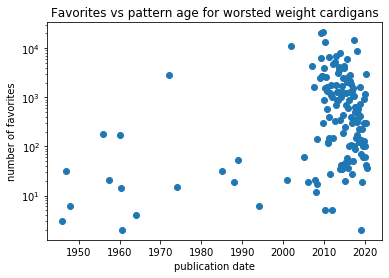

In [76]:
# Make plot of publication date versus number of favorites
x,y = zip(*sorted(plot_data.items()))
plt.plot_date(x,y)
plt.yscale('log') # log scale because of large outliers
plt.xlabel('publication date')
plt.ylabel('number of favorites')
plt.title('Favorites vs pattern age for worsted weight cardigans')

Ravelry didn't exist in 1950! Let's limit the plot to when the website existed. Patterns that were published earlier during the Ravelry era have had more time to be seen on the website and gather attention.

Text(0.5, 1.0, 'Favorites vs pattern age for worsted weight cardigans')

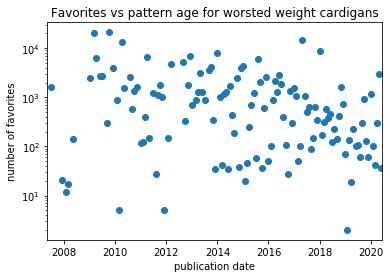

In [77]:
plt.plot_date(x,y)
plt.yscale('log') # log scale because of large outliers
plt.xlim([date(2007, 5, 1), datetime.now()])
plt.xlabel('publication date')
plt.ylabel('number of favorites')
plt.title('Favorites vs pattern age for worsted weight cardigans')

This plot doesn't show a clear relationship between the age of a pattern and the number of favorites. I'll do a linear fit to see if it explains any of the variance.

In [78]:
X=[(item - date(1900,1,1)).days for item in x]
X=tuple(X) # consistent with y

# fit exponetial line
p = np.polyfit(X, np.log(y), 1)

# get r-squared value
r = np.corrcoef(X, np.log(y))
print('R^2 = ',str(r[0,1]**2))

# generate line to plot with data
date_list = [date(2007,5,1) + timedelta(days=d) for d in range(20*365)]
days_list = [(my_date - date(1900,1,1)).days for my_date in date_list]
my_fit = np.exp([num * p[0] for num in days_list] + p[1])

R^2 =  0.13702256439935778


With a low R<sup>2</sup> value, this fit doesn't explain much of the variability in the post 2007 data - supporting what we saw in the plots above. Next we'll add this fit to the graph to help visualize that. 

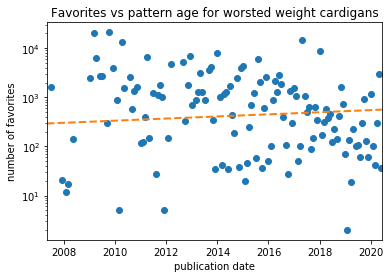

In [79]:
plt.plot_date(x,y)
plt.yscale('log') # log scale because of large outliers
plt.xlim([date(2007, 5, 1), datetime.now()])
plt.xlabel('publication date')
plt.ylabel('number of favorites')
plt.title('Favorites vs pattern age for worsted weight cardigans')
plt.plot(date_list, my_fit , linewidth = 2, linestyle = 'dashed')

Based on this analysis, it doesn't seem like the age of a cardigan pattern has a lot to do with the number of favorites it has for patterns that were published during the Ravelry era, other than a very slight tendency for newer patterns to have more favorites.
So what else could affect the number of favorites? People find patterns on Ravelry in many different ways. They could see it on the Hot Right Now page, in a knitting store, on a blog, from a pattern search, or from a podcast. This data set showed that the differences in the number of favorites a pattern spans several orders of magnitude - some patterns reach a wide audience, and some even go viral.  